<hr style="height:0px; visibility:hidden;" />

<h1><center>6. Amplicon analysis</center></h1>


<div class="alert alert-block alert-success">
Following the standard processing we performed in the previous notebook, now we're ready to start getting into some analysis! As mentioned before, R can be busy and messy when we aren't that used to it yet (and even still when we are used to it). Don't feel like you need to digest and completely understand all of the R code right away; the concepts are more important than specific code.
</div>

---

<center>This is notebook 6 of 6 of <a href="00-overview.ipynb">GL4U's Amplicon Bootcamp</a>. It is expected that the previous notebooks have been completed already.</center>

---

[**Previous:** 5. Amplicon processing](05-amplicon-processing.ipynb)
<br>

<div style="text-align: right"><a href="00-overview.ipynb"><b>Back to:</b> Overview</a></div>

---
---

## Setting up our environment

### Loading libraries

In [ ]:
library(tidyverse)
library(phyloseq)
library(vegan)
library(dendextend)
library(DESeq2)

### Setting our location and some variables

In [ ]:
setwd("~/GL4U-amplicon-tutorial/")

In [ ]:
list.files()

In [ ]:
final_outputs_dir <- "final-outputs"

In [ ]:
# reading in our sample info table and making a variable holding just the sample names like we did earlier
sample_info_tab <- read.table(file = "sample-info.tsv", header = TRUE, sep = "\t", row.names = 1)
sample_names <- row.names(sample_info_tab)
sample_names

---

## Reading in processed data

Here we’re primarily going to be working with our count table, our taxonomy table, and our sample info table.

In [ ]:
# reading in our newly generated count table in a similar fashion as we've done previously
count_tab <- read.table(file = paste0(final_outputs_dir, "/ASV_counts.tsv"), header = TRUE, row.names = 1, sep = "\t")

<div class="alert alert-block alert-info">
    
Note that here we are using the `paste0()` function to make the argument that we are passing to `file =`. Nesting functions like this can get messy if we do too many, but sometimes they are more convenient than adding another separate line. 

</div>

And it's always good to visually check that our table was read-in the way we expect:

In [ ]:
head(count_tab)

In [ ]:
# now reading in the taxonomy table in the same way as above
tax_tab <- read.table(paste0(final_outputs_dir, "/ASV_taxonomy.tsv"), header = TRUE, row.names = 1, sep = "\t")

In [ ]:
head(tax_tab)

---

## Beta diversity

Beta diversity involves calculating metrics such as distances or dissimilarities based on pairwise comparisons of samples – they don’t exist for a single sample, but rather only as metrics that relate samples to each other. Typically one of the first things I do when I get a new dataset into R (whether it’s marker-gene data like this, or gene expression data, or really anything) is generate some exploratory visualizations like ordinations and hierarchical clusterings. These give us a quick overview of how our samples relate to each other and can be a way to check for problems like batch effects.

We’re going to use Euclidean distances to generate some exploratory visualizations of our samples. Since differences in sampling depths between samples can influence distance/dissimilarity metrics, we first need to somehow normalize across our samples.

<center><b>SIDE BAR: Normalizing for sampling depth</b></center>

Previously common ways to normalize for differences in sampling depth (i.e., differing numbers of reads per sample) involved either subsampling each sample down the the lowest sample’s depth, or turning counts into proportions of the total for each sample. However, both of these approaches are generally shunned by people I trust when it comes to such topics (i.e., statisticians). For example, in their [PLOS Computational Biology paper, “Waste not, want not: why rarefying microbiome data is inadmissible”](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003531), McMurdie and Holmes show that there are much better methods of normalizing across samples, such as using a variance stabilizing transformation – which we can do with the DESeq2 package that we already have loaded (you can find more info about this in [Data transformations and visualization section](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#data-transformations-and-visualization) of the DESeq2 manual if wanted).

First, we need to make a DESeq2 object:

In [ ]:
deseq_counts <- DESeqDataSetFromMatrix(countData = count_tab, colData = sample_info_tab, design = ~1)
    # we need to include the colData and design arguments, but for our purposes here they are not being used for anything

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `DESeqDataSetFromMatrix()`      - the primary function we're using
    - `countData = `       - where we specify the input count table
    - `colData = `         - where we provide the sample information table
    - `design = `          - where we provide a formula describing how the samples relate as per the information in the sample information table (`~1` is for no design, which is fine since we are not doing any testing with this object)

</div>

Now, we can create an object with the counts transformed:

In [ ]:
deseq_counts_vst <- varianceStabilizingTransformation(deseq_counts)

And, the DESeq2 `assay()` function let's us pull out just that table of the transformed counts:

In [ ]:
vst_trans_count_tab <- assay(deseq_counts_vst)

In [ ]:
head(vst_trans_count_tab)

Next, we are going to calculate a Euclidean distance matrix of our samples, based on the transformed counts. Note that we are transposing the table (with the `t()` function), just because the `dist()` function expects the rows to be the items we want to calculate distances for:

In [ ]:
euc_dist <- dist(t(vst_trans_count_tab))

In [ ]:
euc_dist

### Hierarchical clustering

Now that we have our Euclidean distance matrix, let's make and plot a hierarchical clustering of our samples.

In [ ]:
euc_clust <- hclust(d = euc_dist, method = "ward.D2")

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `hclust()`      - the primary function we're using
    - `d = `       - where we specify the input dissimilarity or distance object
    - `method = `  - where we specify the method of clustering to use (we could see all options with `?hclust`)

</div>

We can just plot that as is:

In [ ]:
plot(euc_clust)

But we can also run a few other lines to plot it colored, which can be helpful:

In [ ]:
euc_dend <- as.dendrogram(euc_clust, hang = 0.1)
dend_cols <- sample_info_tab$color[order.dendrogram(euc_dend)]
labels_colors(euc_dend) <- dend_cols

In [ ]:
plot(euc_dend, ylab = "VST Euc. dist.")

Glancing at that clustering, it looks as though ground samples G3 and G5 are the most dissimilary from the rest, with flight samples F3 and F5 slightly grouping with the remaining ground samples more so than with the the other flight samples. An ordination is another way to see how samples relate to each other on a broad scale. 

### Ordination

Generally speaking, ordinations provide visualizations of sample-relatedness based on dimension reduction. The ‘dimensions’ could be whatever we measured in each sample, which in our case here is counts of ASVs. Principle coordinates analysis (PCoA) is a type of multidimensional scaling that operates on dissimilarities or distances. Here we’re going to generate and plot our PCoA using functions from the *phyloseq* package. But because we’re still doing beta diversity here (comparing samples to each other), we want to use our transformed table we created above. So we’re first going to make a phyloseq object with our DESeq2-transformed table and then generate the PCoA from that.

In [ ]:
# making our phyloseq object with transformed table
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows = TRUE)
sample_info_tab_phy <- sample_data(sample_info_tab)
vst_physeq <- phyloseq(vst_count_phy, sample_info_tab_phy)

In [ ]:
vst_physeq

In [ ]:
# generating a visualizing the PCoA with phyloseq
vst_pcoa <- ordinate(vst_physeq, method = "MDS", distance = "euclidean")

# pulling out eigen values of the ordiation, 
    # this allows us to scale the axes according to their magnitude of separating apart the samples
eigen_vals <- vst_pcoa$values$Eigenvalues

<div class="alert alert-block alert-warning">
<b>A note on plotting code</b>
<br>
Plotting in particular can look very busy and confusing. Each time I plot something new, it is always starting from a template of a previous plot I made or found, and then just tweaking that until it works for what I want. Because they are busy and beyond our scope here, we won't be breaking down all of the plotting codes as we go, but don't be intimidated by it. Looking at them all together is confusing for most of us!

</div>

In [ ]:
plot_ordination(vst_physeq, vst_pcoa, color = "treatment") + 
    geom_point(size = 1) + labs(col = "treatment") + 
    geom_text(aes(label = rownames(sample_info_tab), hjust = 0.3, vjust = -0.4)) + 
    coord_fixed(sqrt(eigen_vals[2]/eigen_vals[1])) + 
    scale_color_manual(values = unique(sample_info_tab$color[order(sample_info_tab$treatment)])) + 
    theme_bw() + theme(legend.position = "none",  text = element_text(size = 15)) + ggtitle("PCoA")

Again it seems G3 and G5 are kind of out on their own. This is just providing us with a different overview of how our samples relate to each other. Inferences that are consistent with the hierarchical clustering above could be considered a bit more robust if the same trends emerge from these slightly different views into the data. It's important to remember that these by themselves are just exporatory visualizations, and they don't say anything statistically about our samples.

The scaled axes we generated by pulling out the eigen values help convey that the x-axis is capturing much more variation than the y-axis is. If we didn't do that, the plot would just be a square, like this:

In [ ]:
# here's one without scaling the axes
plot_ordination(vst_physeq, vst_pcoa, color = "treatment") + 
    geom_point(size = 1) + labs(col = "treatment") + 
    geom_text(aes(label = rownames(sample_info_tab), hjust = 0.3, vjust = -0.4)) + 
#     coord_fixed(sqrt(eigen_vals[2]/eigen_vals[1])) + 
    scale_color_manual(values = unique(sample_info_tab$color[order(sample_info_tab$treatment)])) + 
    theme_bw() + theme(legend.position = "none",  text = element_text(size = 15)) + ggtitle("PCoA")

<div class="alert alert-block alert-info">

Plotting these with scaled axes like done first above is a better representation of what this ordination is actually showing us than what this view provides.

</div>

This is just providing us with a different overview of how our samples relate to each other. Inferences that are consistent with the hierarchical clustering above can be considered a bit more robust if the same general trends emerge from both approaches. It’s important to remember that these are exploratory visualizations and do not say anything statistically about our samples.

---

## Alpha diversity

Alpha diversity entails using summary metrics that describe individual samples, and it is a very tricky thing when working with amplicon data. There are a lot of tools from macro-ecology that have been co-opted into the microbial ecology world unchecked that unfortunately just simply do not work the same way. Alpha diversity metrics with sequencing data are really only useful as summary metrics for relative comparisons of samples from the same experiment that were processed the same way. 

**Here are some fundamental terms we will encounter in this section:**

- **richness** - the total number of distinct units in a sample (like could be number of unique species if counting macrofauna)
- **evenness** - how close in number each distinct unit is in a sample (so a sample with 3 different unique, species each seen 5 times would have a high evenness)
- **diversity** - a combination of *richness* and *evenness*

### Rarefaction curves

First thing’s first, it is not okay to use rarefaction curves to estimate total richness of a sample, or to extrapolate anything from them really, but they can still be useful in filling out our mental landscape of our samples depending on the data. We’ll be using the `rarecurve()` function, which expects the rows to be samples and the observations (our ASVs here) to be columns, which is why we are transposing table we are giving it with the `t()` function:

In [ ]:
rarecurve(x = t(count_tab), step = 100, col = sample_info_tab$color, lwd = 2, ylab = "ASVs", label = FALSE)

This type of plot is meant to serve as a visual representation of one way of looking at the diversity that exists in the samples. The x-axis represents each time we are "pulling out" a sequence, and the y-axis represents how many unique sequences we've pulled out. 

The lines being practically vertical right off the start for all samples tells us that these are not very diverse samples. Looking across, even when we pull out about 20,000 different sequences, we've only found about 50-60 unique sequence types. 

Sample from a more diverse environment might look something more like this:

<center>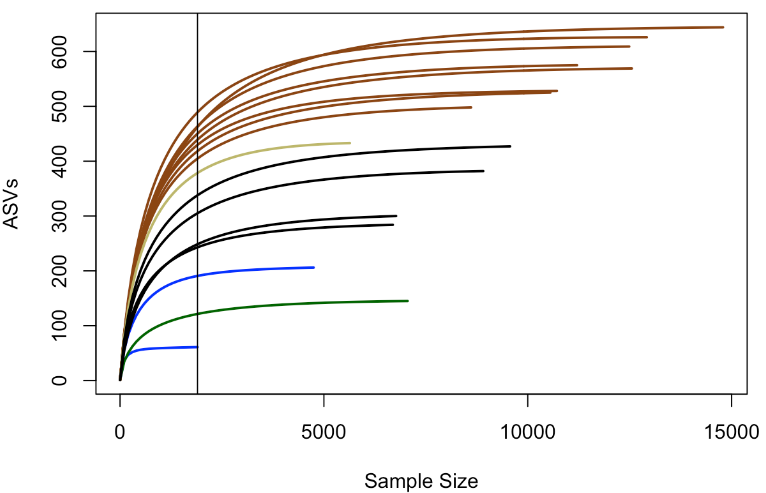</center>

Where the blue lines (water samples) have about 50-200 unique sequences recovered after about 2,000 being sampled, while the brown lines at the top (which come from deepsea basalts) have about 400-500 unique sequences after about 2,000 being sampled.

### Richness and diversity estimates

Next we’re going to plot Chao1 richness esimates and Shannon diversity values. 

Chao1 is a richness estimator. As mentioned above, “*richness*” represents the total number of distinct units in our sample – with “distinct units” being whatever we happen to be measuring (ASVs in our case here). And Shannon’s diversity index is a metric of diversity, with "diversity" including the concepts of richness and *evenness* (the relative proportions of all of our distinct units to each other). As stated previously, when it comes to sequencing data, these are really just metrics to help contrast our samples within an experiment, and should not be considered “true” values of anything or be compared across different studies that may have been sequenced or processed differently. This is because any little change in sequencing or processing can drastically affect these values, making them incomparable unless generated in as much the same way as possible.

We are going to go back to using the phyloseq package for this to use their function `plot_richness()` – which the developers kindly provide some examples of [here](https://joey711.github.io/phyloseq/plot_richness-examples.html). First we need to create a phyloseq object using our un-transformed count table this time:

In [ ]:
count_tab_phy <- otu_table(count_tab, taxa_are_rows = TRUE)
tax_tab_phy <- tax_table(as.matrix(tax_tab))
ASV_physeq <- phyloseq(count_tab_phy, tax_tab_phy, sample_info_tab_phy)

And now we can all the `plot_richness()` function on our phyloseq object:

In [ ]:
plot_richness(ASV_physeq, color = "treatment", measures = c("Chao1", "Shannon")) + 
    scale_color_manual(values = unique(sample_info_tab$color)) +
    theme_bw() + 
    theme(legend.title = element_blank(), text = element_text(size = 18),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

Before saying anything about this I’d like to stress again that these are not interpretable as “real” numbers of anything (due to the nature of the sequencing and processing of amplicon data), but they can still be useful as relative metrics of comparison within a study. These two groups of samples don't seem to immediately show any clear differences. The left "Chao1" is an estimate of total richness (total number of unique "things"); and the right is a metric of diversity – which incorporates "richness" and "evenness" (the relative proportions of all our unique things relative to each other). Maybe the richness seems to have a higher spread overall in the flight samples as compared to the ground samples (left plot), and other than samples G3 and G5, the diversity of the other 3 ground samples seems to be much lower (right plot).

We can also use phyloseq to group these based on our groups: 

In [ ]:
plot_richness(ASV_physeq, x = "treatment", color = "treatment", measures = c("Chao1", "Shannon")) + 
    scale_color_manual(values = unique(sample_info_tab$color)) +
    theme_bw() + theme(legend.title = element_blank(), text = element_text(size = 18),
                       axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

---

## Taxonomic summaries

Taxonomy is a fickle beast. Here are a few contributing reasons as to why:

1. It’s important to remember that taxonomic delineations are arbitrary, they’re not fundamental units of biology. That doesn’t negate the utility of taxonomy, of course, but it’s worth mentioning because sometimes it’s easy to forget.

2. Like all things that use a reference database and any method, taxonomic classification is entirely dependent on the reference database and the method we use.

3. Taxonomic assignment from a short fragment of a gene is difficult, even if it’s a relatively useful marker like a portion of the 16S gene. There are many cases where even a perfect reference database and method still wouldn’t be able to delineate between different source-organisms (because the fragment we have sequenced can be 100% identical between different organisms).

And just to mention it, we cannot achieve “strain-level” resolution with a short fragment of one gene. All we can say is how similar that sequence is to another sequence. It doesn’t necessarily tell us pertinent information about the source genome that sequence came from.

All those caveats out of the way, taxonomy is still useful and necessary, of course! What we did to assign taxonomic classifications to all our ASVs was done in a rapid, high-throughput fashion, by necessity. For sequences that become important in your story, you could consider pulling them out and BLASTing them and/or comparing them to other databases.

Taxonomic summary figures usually aren’t all that exciting, but they can still be useful, and they’re certainly still a reasonable way to present a summary of our data (all caveats included – like recovered amplicon sequences do not equal organisms, or genomes, or cells). Here we’ll make some broad-level summarization figures. Phyloseq is also very useful for parsing things down by taxonomy now that we’ve got all that information in there. So we’ll be using that where we can. 

Let’s make a summary of all phyla proportions across all samples, which is typically a fine way to summarize things when we want an overview and we aren’t already looking for something specific.

We can use our phyloseq object and one of their helper functions to summarize things based on identified phyla:

In [ ]:
# this creates a phyloseq object that has all counts normalized to be proportions of the total per sample
proportions_physeq <- transform_sample_counts(ASV_physeq, function(ASV) ASV / sum(ASV))

In [ ]:
plot_bar(proportions_physeq, fill = "phylum") + theme_bw() + 
    theme(text = element_text(size = 18))

These are all clearly dominated by some member of Bacteroidota and the some Firmicutes. But a phylum-level summary view like this isn't going to be that much more informative with these samples.

We can also group them by our factor if we wanted:

In [ ]:
plot_bar(proportions_physeq, x = "treatment", fill = "phylum") + theme_bw() + 
    theme(text = element_text(size = 18))

Taxonomic summary figures aren't always helpful, but they also get more of a bad wrap than they deserve. Some different types could include pie charts and boxplots too, like some examples [here](https://astrobiomike.github.io/amplicon/dada2_workflow_ex#taxonomic-summaries). 

---

## Statistically testing for differences

### Betadisper and permutational ANOVA

As we saw earlier, we have some information about our samples in our sample info table, namely our Flight vs Ground groups. A common way to test if group information is indicative of community structure is with a permutational ANOVA test. Here we are going to test if there is a statistically signficant difference between our sample types (Flight and Ground). One way to do this is with the `betadisper` and `adonis2` functions from the vegan package. `adonis2` can tell us if there is a statistical difference between groups, but it has an assumption that must be met that we first need to check with `betadisper`, and that is that there is a sufficient level of homogeneity of dispersion within groups. If there is not, then `adonis2` can be unreliable.

In [ ]:
betadisper(d = euc_dist, group = sample_info_tab$treatment) %>% anova()

<div class="alert alert-block alert-info">
<b>Function breakdown</b>
<br>

- `betadisper()` - function for testing for homogeneity of group dispersions
    - `d = `     - the input distance object
    - `group = ` - the grouping information
    
- `%>% anova()`       - we send the output object from the `betadisper()` function into the `anova()` function

</div>

This gives us roughly a result of ~0.34, which is typically not in the realm of what folks would consider significant. This tells us that there is *not* a significant difference between group dispersions, which means that we *can* trust the results of a permutational anova test on this. If that weren't the case, and the p-value returned from `betadisper()` was in the realm of what we would consider significant, we would *not* be able to test these data with a permutational anova.

Here is how we can test if the communities overall are different based on the treatment (flight/ground):

In [ ]:
adonis2(formula = euc_dist ~ sample_info_tab$treatment, permutations = 999)

<div class="alert alert-block alert-info">
<b>Function breakdown</b>
<br>

- `adonis2()`           - function for testing for homogeneity of group dispersions
    - `formula = `      - the model formula to use, left is our distance matrix, right is our grouping info
    - `permutations = ` - the number of permutations to run

</div>

The `adonis2()` function "permutes" the data by randomly associating the grouping information with the samples and seeing how likely it is we would see the relationships we do see (based on our distance matrix) if there were actually no relationship between the groups and the sample distances.

And here we are getting p-values that range more in the realm of what we typically consider significant. Since these are random permutations, it can vary slightly, but running it multiple times we are consistently jumping around 0.01 or lower, providing our first statistical evidence that there is actually a difference in microbial communities overall between the flight and ground groups.

Sometimes it can be useful to incoporate this into a visualization, so let's recreate the PCA we made above, showing an overview of our sample relatedness, and then add text showing this result:

In [ ]:
plot_ordination(vst_physeq, vst_pcoa, color = "treatment") + 
    geom_point(size = 1) + labs(col = "treatment") + 
    geom_text(aes(label = rownames(sample_info_tab), hjust = 0.3, vjust = -0.4)) + 
    coord_fixed(sqrt(eigen_vals[2]/eigen_vals[1])) + 
    scale_color_manual(values = unique(sample_info_tab$color[order(sample_info_tab$treatment)])) + 
    theme_bw() + theme(legend.position = "none",  text = element_text(size = 15)) + ggtitle("PCoA") +
    annotate("text", x = -9, y = -3, label = "Flight vs Ground", size = 5) +
    annotate("text", x = -9, y = -4, label = "Permutational ANOVA = 0.01", size = 5)

There might be packages that try to auto-place overlain text like above, but I don't find it too inconvenient to just find an ideal place by testing and changing the `x` and `y` arguments to the `annotate()` functions above. Those are the only changes from the initial PCoA plot we did above. 

As mentioned, this tells us there is a difference at the whole community level, next we'll look at one way to check for differences of individual ASV sequences.

### Differential abundance analysis with DESeq2

First, it’s important to reiterate again that:

<center><b>Recovered 16S rRNA gene copy numbers do not equal organism abundance.</b></center>

That said, recovered 16S rRNA gene copy numbers do represent… well, numbers of recovered 16S rRNA gene copies. So long as we’re interpreting them that way, and thinking of our system in the appropriate way, we can perform differential abundance testing to test for which sequences have significantly different copy-number counts between samples – which can still be useful information and guide the generation of hypotheses. One tool that can be used for this is DESeq2, which we used above to transform our count table for beta diversity plots.

Now that we’ve found a statistical difference between our two rock samples, this is one way we can try to find out which ASVs (and possibly which taxa) are contributing to that difference. If you are going to use DESeq2, be sure to carefully go over their thorough manual and other information you can find [here](https://bioconductor.org/packages/release/bioc/html/DESeq2.html), particularly [their very helpful vignette here](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html). 

Here, we are going to take advantage of another phyloseq convenience and use the `phyloseq_to_deseq2` function to make our DESeq2 object:

In [ ]:
deseq_obj <- phyloseq_to_deseq2(physeq = ASV_physeq, design = ~treatment)

And now we can run the DESeq primary function to test for differential abundance:

In [ ]:
deseq_modeled <- DESeq(deseq_obj)

The `DESeq()` function is doing a lot of things for us, including normalizing for sampling depth (number of reads per sample), transforming the data, and testing for differential abundance between the groups in our treatment factor. There is detailed information about all of these processes at the [page linked above](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html). 

We can now access the results with the `results()` function. With our setup here, we only have 2 groups, so what is being contrasted is pretty straightforward. If there were more, we would tell the `results()` function which groups we would like to have contrasted (all contrasts were done at the `DESeq2()` function call above, but we would parse those results by specifying now if needed). Even though we don't need to include it here, here is how we can tell it to get the results for the contrast of flight vs ground: 

In [ ]:
deseq_res <- results(deseq_modeled, contrast = c("treatment", "flight", "ground"))

We can peek at this object just by running it by itself, and it will preview the full table it holds:

In [ ]:
deseq_res

This shows us some info about the contrast at the top, which test was used, and then has columns of some information for each ASV. Primary ones of interest typically include:
- **baseMean**: the mean across all samples after they were normalized for read depth
- **log2FoldChange**: the `log2(flight / ground)` in this case
    - these results are typically conveyed in log2 because it makes everything that is increased go from 0 and up, and anything that is decreased go from 0 down, on a symmetrical scale (see the first 2 figures on [this page](http://rstudio-pubs-static.s3.amazonaws.com/13988_bb11d85b79b2436280de434988558140.html) for some plotting examples of this) - without this log2 representation, all things increase would go from 1 to infinity, and all things decreased would be crammed in 0 to 1
    - here, a log2 fold-change of 1 would mean 2x greater in flight than ground, 2 would mean 4x greater, and so on; while a log2 fold-change of -1 would mean 2x greater in ground than flight
- **lfcSE**: the standard error of the log2fold change
- **stat**: the test statistic
- **pvalue**: the un-adjusted p-value of the test (smaller = stronger evidence the effect we see is due to an actual difference between treatments; though when testing many things like is done here, we shouldn't rely on this value, and instead look at the padj next) 
- **padj**: the adjusted p-value of the test (needed to account for the multiple hypothesis testing that was done)

The adjusted p-value is what we should use for our significance cutoff. Just like with regular p-values, there is no magic cutoff that is appropriate in all cases. It's not unusual for folks to use 0.1 as an adjusted p-value threshold, and that is the default in DESeq2. 

We can see a summary of these results with the `summary()` function:

In [ ]:
summary(deseq_res)

Which tells us how many ASVs were called differentially abundant based on how we've processed things and the 0.1 adjusted p-value cutoff. Let's look at those considered significatn based on that cutoff:

In [ ]:
deseq_res %>% data.frame() %>% filter(padj < 0.1)

The first one, ASV_3 here, say's it's log2FolChange is about -1.4. With how we set the contrast up, it is comparing Flight vs Ground, so Flight is the numerator and Ground is the denominator. And remember with log2FoldChange, a value of 1 would mean 2x greater in the numerator, and a log2FoldChange value of 2 would mean 4x greater in the numerator. Since we have a **-1.4** here, it's somewhere in between being 2 and 4 times greater in ground vs flight. But we can try to take a look by breaking it down.

As noted above, in this case log2FoldChange = log2(flight / ground).

So we can:
1. get the normalized counts for each group for this ASV
2. get their means
3. divide the flight mean by the ground mean to get the fold change between the two
4. get the log2 value of that ratio

**(1)** Let's pull out the normalized count table from the DESeq2 object, and then just get the counts of ASV_3 for flight and ground:

In [ ]:
norm_tab <- counts(deseq_modeled, normalized = TRUE) %>% data.frame()

In [ ]:
head(norm_tab)

And since these are in order, here is one quick way we can just pull out the row for ASV 3:

In [ ]:
norm_tab[3, ]

At a glance, it looks like it is generally higher in the ground samples. Let's get the values for flight and ground separately and store them in R objects:

In [ ]:
asv_3_norm_flight <- norm_tab[3, 1:5] %>% as.numeric() 
asv_3_norm_ground <- norm_tab[3, 6:10] %>% as.numeric() 

In [ ]:
asv_3_norm_flight
asv_3_norm_ground

**(2)** Now let's get their means:

In [ ]:
asv_3_norm_flight_mean <- mean(asv_3_norm_flight)
asv_3_norm_ground_mean <- mean(asv_3_norm_ground)

In [ ]:
asv_3_norm_flight_mean
asv_3_norm_ground_mean

**(3)** Here is calculating the base fold change:

In [ ]:
asv_3_flight_vs_ground_fold_change <- asv_3_norm_flight_mean / asv_3_norm_ground_mean

In [ ]:
asv_3_flight_vs_ground_fold_change

**(4)** And here is calculating the log2FoldChange:

In [ ]:
log2(asv_3_flight_vs_ground_fold_change)

Which is pretty spot on with the value reported in the primary DESeq2 output table:

In [ ]:
deseq_res %>% data.frame() %>% filter(padj < 0.1) %>% head(1)

What we did above won't always lead to exactly the same result as DESeq2 reports because we didn't incorporate everything DESeq2 is actually doing, namely it performs shrinkage of the fold change estimates in cases where the values are expected to be less precise (like due to higher variance or low counts). 

---

## So now what?
Above we performed some of the standard steps that are typical to do. Here’s where our questions and the experimental design (if there is one) start to guide how we go further. Amplicon sequencing can be used for diagnostic purposes, when we know what we're looking for, but it is often often used as an initial exploratory tool, largely helpful for hypothesis generation. If there is a priori something specific to look for, then great, and we can look for that. If not, and our study is just about describing what is there as a first pass in beginning to shape our understanding of something, then that’s great too. Basically, up to now was just standard processing and analysis, and now would be where the science part starts 🙂

---
---

[**Previous:** 5. Amplicon processing](05-amplicon-processing.ipynb)
<br>

<div style="text-align: right"><a href="00-overview.ipynb"><b>Back to:</b> Overview</a></div>
